In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/loic/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


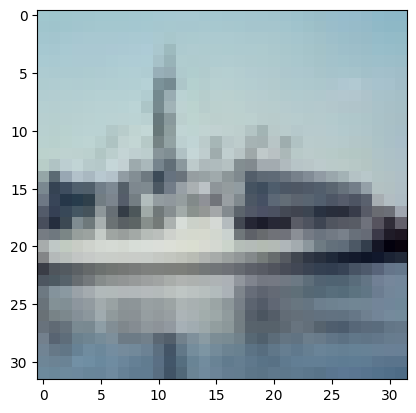

ship 


In [75]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [66]:
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.513
[1,  4000] loss: 0.523
[1,  6000] loss: 0.514
[1,  8000] loss: 0.514
[1, 10000] loss: 0.523
[1, 12000] loss: 0.517
[2,  2000] loss: 0.521
[2,  4000] loss: 0.511
[2,  6000] loss: 0.509
[2,  8000] loss: 0.535
[2, 10000] loss: 0.521
[2, 12000] loss: 0.516
[3,  2000] loss: 0.521
[3,  4000] loss: 0.514
[3,  6000] loss: 0.521
[3,  8000] loss: 0.526
[3, 10000] loss: 0.518
[3, 12000] loss: 0.503
[4,  2000] loss: 0.515
[4,  4000] loss: 0.531
[4,  6000] loss: 0.530
[4,  8000] loss: 0.510
[4, 10000] loss: 0.518
[4, 12000] loss: 0.508
[5,  2000] loss: 0.516
[5,  4000] loss: 0.526
[5,  6000] loss: 0.516
[5,  8000] loss: 0.513
[5, 10000] loss: 0.522
[5, 12000] loss: 0.510
[6,  2000] loss: 0.508
[6,  4000] loss: 0.514
[6,  6000] loss: 0.519
[6,  8000] loss: 0.512
[6, 10000] loss: 0.513
[6, 12000] loss: 0.540
[7,  2000] loss: 0.517
[7,  4000] loss: 0.501
[7,  6000] loss: 0.524
[7,  8000] loss: 0.515
[7, 10000] loss: 0.517
[7, 12000] loss: 0.530
[8,  2000] loss: 0.514
[8,  4000] 

In [68]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

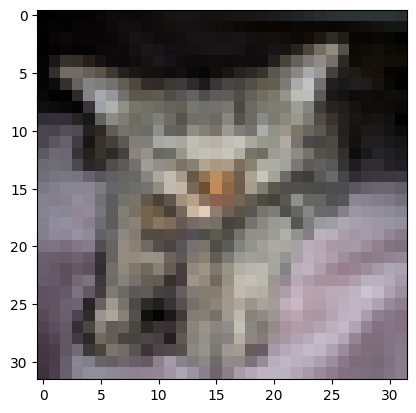

GroundTruth:  cat  


In [90]:
#dataiter = iter(testloader)
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))

In [91]:
net = Net()
net.load_state_dict(torch.load(PATH))


outputs = net(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(1)))

Predicted:  deer 


In [92]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [93]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 66.1 %
Accuracy for class: car   is 75.5 %
Accuracy for class: bird  is 52.8 %
Accuracy for class: cat   is 37.5 %
Accuracy for class: deer  is 61.0 %
Accuracy for class: dog   is 53.7 %
Accuracy for class: frog  is 70.0 %
Accuracy for class: horse is 69.9 %
Accuracy for class: ship  is 75.3 %
Accuracy for class: truck is 72.9 %


In [ ]:
del dataiter